# TCJA Permanency Act
To run this notebook, you need the following:
1. Fork the repository https://github.com/OpenSourceEcon/TCJAperm and clone it to your local machine.
2. Navigate to the `/TCJAperm/` directory in your terminal and create the `tcjaperm-dev` conda environment by typing: `conda env create -f environment.yml`
3. Open the `TCJA_perm_taxcalc.ipynb` notebook and set the kernel in the notebook to the `tcjaperm-dev` conda environment.
4. Execute the cells in the `TCJA_perm_taxcalc.ipynb` notebook.
    * You will need to adjust the file path to the `puf.csv` file in code cell 2 and the path to the `TCJA_perm.json` file in code cell 3.
    * If you do not have the IRS Public Use File, then you will need to use the CPS file included with Tax-Calculator. That code is commented out in cell 2.

In [1]:
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import taxcalc as tc
import matplotlib.pyplot as plt

In [2]:
puf_path = (
    "/Users/richardevans/Docs/Economics/OSE/Tax-Calculator/taxcalc/puf.csv"
)
recs = tc.Records(data=puf_path)
# If you need to use the CPS data file included with Tax-Calculator, comment
# out the previous lines in this cell and uncomment the following line.
# recs = tc.Records.cps_constructor()
pol = tc.Policy()
calc_base = tc.Calculator(policy=pol, records=recs)
CYR = 2024
calc_base.advance_to_year(CYR)
calc_base.calc_all()
itax_rev_base = calc_base.weighted_total('iitax')

In [3]:
reform_json_path = (
    "/Users/richardevans/Docs/Economics/OSE/TCJAperm/json/TCJA_perm.json"
)
params_ref1 = pol.read_json_reform(reform_json_path)
pol.implement_reform(params_ref1)
calc_ref1 = tc.Calculator(policy=pol, records=recs)

In [4]:
# Compute annual revenue for each year in a 10 year budget window
# Do this for with and without the ARPA
rev_base = {'IIT': {}, 'Payroll': {}}
rev_ref1 = {'IIT': {}, 'Payroll': {}}
for t in range(2024, 2034):
    calc_base.advance_to_year(t)
    calc_base.calc_all()
    calc_ref1.advance_to_year(t)
    calc_ref1.calc_all()
    rev_base['IIT'][t] = calc_base.weighted_total('iitax')
    rev_base['Payroll'][t] = calc_base.weighted_total('payrolltax')
    rev_ref1['IIT'][t] = calc_ref1.weighted_total('iitax')
    rev_ref1['Payroll'][t] = calc_ref1.weighted_total('payrolltax')

In [5]:
# make table of revenue estimates
rev_base_df = pd.DataFrame.from_dict(rev_base).T
rev_ref1_df = pd.DataFrame.from_dict(rev_ref1).T
diff_df = (rev_ref1_df - rev_base_df) * 1e-9  # in $ billions
pd.options.display.float_format = '${:.3f}'.format
diff_df['2024-2033'] = diff_df.sum(axis=1)
# print(diff_df.to_latex())
diff_df

,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2024-2033
IIT,$0.000,$0.000,$-29.243,$-27.224,$-25.339,$-23.578,$-21.615,$-20.117,$-17.387,$-9.473,$-173.975
Payroll,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000,$0.000


In [ ]:
diff_df.index

# Average Tax Rates for 2026

In [8]:
# Restart calculation to get back to 2026
pol_2026 = tc.Policy()
calc_base_2026 = tc.Calculator(policy=pol_2026, records=recs)
pol_2026.implement_reform(params_ref1)
calc_ref1_2026 = tc.Calculator(policy=pol_2026, records=recs)
calc_base_2026.advance_to_year(2026)
calc_ref1_2026.advance_to_year(2026)
calc_base_2026.calc_all()
calc_ref1_2026.calc_all()

# get data for plots
mars = 'ALL'
mtr_wrt_full_compen = True
record_variables = ['s006', 'XTOT']
if mars != 'ALL':
    record_variables.append('MARS')
record_variables.append('expanded_income')
record_variables.append('e00200')
vdf = calc_base_2026.dataframe(record_variables)
# create 'tax1' and 'tax2' columns given specified atr_measure
vdf['tax1'] = calc_base_2026.array('iitax')
vdf['tax2'] = calc_ref1_2026.array('iitax')
# compute mtrs for mtr plot data
(mtr_base_ptax, mtr_base_itax, mtr_base_combined) = calc_base_2026.mtr(
    variable_str='e00200p', wrt_full_compensation=mtr_wrt_full_compen
)
(mtr_ref1_ptax, mtr_ref1_itax, mtr_ref1_combined) = calc_ref1_2026.mtr(
    variable_str='e00200p', wrt_full_compensation=mtr_wrt_full_compen
)
vdf['mtr1'] = mtr_base_itax
vdf['mtr2'] = mtr_ref1_itax

mtr_data = tc.calculator.mtr_graph_data(vdf,
                              year=2026,
                              mars=mars,
                              mtr_measure='itax',
                              alt_e00200p_text='This text',
                              mtr_wrt_full_compen=True,
                              income_measure='expanded_income',
                              pop_quantiles=True,
                              dollar_weighting=False)

atr_data = tc.calculator.atr_graph_data(vdf,
                              year=2026,
                              mars=mars,
                              atr_measure='itax',
                              pop_quantiles=True)

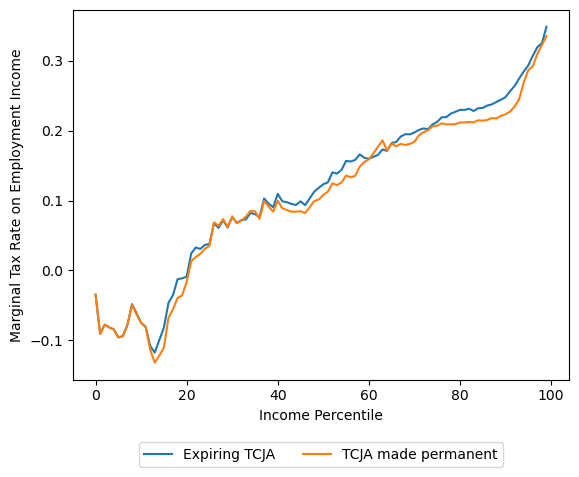

In [9]:
plt.plot(mtr_data['lines'].index, mtr_data['lines'].base.values, label='Expiring TCJA')
plt.plot(mtr_data['lines'].index, mtr_data['lines'].reform.values, label='TCJA made permanent')
plt.xlabel('Income Percentile')
plt.ylabel('Marginal Tax Rate on Employment Income')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.savefig('images/tcja_perm_mtr_plot.png', bbox_inches='tight')

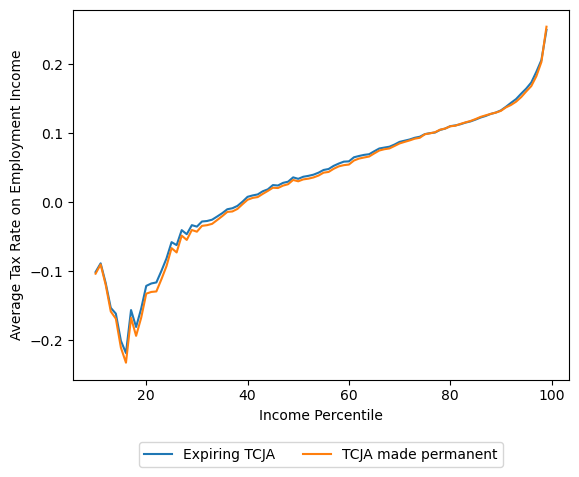

In [10]:
plt.plot(atr_data['lines'].index, atr_data['lines'].base.values, label='Expiring TCJA')
plt.plot(atr_data['lines'].index, atr_data['lines'].reform.values, label='TCJA made permanent')
plt.xlabel('Income Percentile')
plt.ylabel('Average Tax Rate on Employment Income')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.savefig('images/tcja_perm_atr_plot.png', bbox_inches='tight')

# Distributional results

See below + table by Cody

In [ ]:
# Restart calculation to get back to first year
pol = taxcalc.policy.Policy()
tc_base = taxcalc.calculator.Calculator(policy=pol, records=rec)
pol.implement_reform(ref)
tc_arpa = taxcalc.calculator.Calculator(policy=pol, records=rec)
tc_base.advance_to_year(2021)
tc_arpa.advance_to_year(2021)
tc_base.calc_all()
tc_arpa.calc_all()

# get data for plots
mars = 'ALL'
mtr_wrt_full_compen = True
record_variables = ['s006', 'XTOT']
if mars != 'ALL':
    record_variables.append('MARS')
record_variables.append('expanded_income')
record_variables.append('e00200')
vdf = tc_base.dataframe(record_variables)
# create 'tax1' and 'tax2' columns given specified atr_measure
vdf['tax1'] = tc_base.array('iitax')
vdf['tax2'] = tc_arpa.array('iitax')
# compute mtrs for mtr plot data
(mtr1_ptax, mtr1_itax, mtr1_combined) = tc_base.mtr(
    variable_str='e00200p', wrt_full_compensation=mtr_wrt_full_compen)
(mtr2_ptax, mtr2_itax, mtr2_combined) = tc_arpa.mtr(
    variable_str='e00200p', wrt_full_compensation=mtr_wrt_full_compen)
vdf['mtr1'] = mtr1_itax
vdf['mtr2'] = mtr2_itax

mtr_data = taxcalc.calculator.mtr_graph_data(vdf,
                              year=2021,
                              mars=mars,
                              mtr_measure='itax',
                              alt_e00200p_text='This text',
                              mtr_wrt_full_compen=True,
                              income_measure='expanded_income',
                              pop_quantiles=True,
                              dollar_weighting=False)
atr_data = taxcalc.calculator.atr_graph_data(vdf,
                              year=2021,
                              mars=mars,
                              atr_measure='itax',
                              pop_quantiles=True)

In [ ]:
plt.plot(mtr_data['lines'].index, mtr_data['lines'].base.values, label='Pre-ARPA')
plt.plot(mtr_data['lines'].index, mtr_data['lines'].reform.values, label='Post-ARPA')
plt.xlabel('Income Percentile')
plt.ylabel('Marginal Tax Rate on Wage Income')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.savefig('arpa_mtr_plot.png', bbox_inches='tight')

In [ ]:
plt.plot(atr_data['lines'].index, atr_data['lines'].base.values, label='Pre-ARPA')
plt.plot(atr_data['lines'].index, atr_data['lines'].reform.values, label='Post-ARPA')
plt.xlabel('Income Percentile')
plt.ylabel('Average Tax Rate')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.savefig('arpa_atr_plot.png', bbox_inches='tight')

# Tax benefits by family size

In [ ]:
df = tc_base.dataframe(['nu18', 'XTOT', 'iitax', 'c00100', 's006', 'aftertax_income', 'expanded_income'])
df['ARPA_iitax'] = tc_arpa.array('iitax')
df['tax_change'] = df['ARPA_iitax'] - df['iitax']
df['aftertax_income_ARPA'] = tc_arpa.array('aftertax_income')
df.groupby('nu18')[['s006', 'XTOT']].sum()

In [ ]:
mdf.weighted_mean(df, 'nu18', 's006')

In [ ]:
decile_bounds = np.arange(0, 1.1, 0.1)
deciles = mdf.weighted_quantile(df, 'c00100', 's006', decile_bounds)
quintile_bounds = np.arange(0, 1.2, 0.2)
quintiles = mdf.weighted_quantile(df, 'c00100', 's006', quintile_bounds)

In [ ]:
df_group = mdf.weighted_mean(df, 'tax_change', w='s006', groupby=['nu18'])
df_group.plot.bar()

In [ ]:
from cycler import cycler
from cycler import cycler
N = 7
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Blues(np.linspace(0.2,1,N)))


df['quintiles'] = pd.cut(df['expanded_income'], bins=quintiles, labels=np.arange(1,6).tolist())
df_group = pd.DataFrame(mdf.weighted_mean(df, 'tax_change', w='s006', groupby=['nu18', 'quintiles']))
# df_group.plot.bar()
df_group.reset_index(inplace=True)
df_group.rename(columns={0: 'Average Change in Taxes', 'nu18': 'Number of Children', 'quintiles': 'Income Quintiles'}, inplace=True)
df_group['Number of Children'] = df_group['Number of Children'].astype('int64')
ax1 = df_group.pivot("Income Quintiles", "Number of Children", "Average Change in Taxes").plot(kind='bar', alpha=1.0)
plt.ylabel('Mean Tax Change')
plt.xticks(rotation = 0)
plt.legend(title='Number of Children', loc=9, bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.savefig('bar_plot_by_kids.png', bbox_inches='tight')

In [ ]:
df.drop(df[df['expanded_income'] < 0].index, inplace=True)
percentile_bounds = np.arange(0, 1.01, 0.01)
percentiles = mdf.weighted_quantile(df, 'expanded_income', 's006', percentile_bounds)
df['Percentile'] = pd.cut(df['expanded_income'], bins=percentiles, labels=np.arange(1,101).tolist())
df_group = pd.DataFrame(mdf.weighted_mean(
    df, ['aftertax_income', 'aftertax_income_ARPA'], w='s006', groupby='Percentile'))
df_group.reset_index(inplace=True)
df_group.plot(kind='line', alpha=1.0)
plt.ylim([0, 50000])
# plt.ylabel('Mean Tax Change')
# plt.xticks(rotation = 0)
# plt.legend(title='Number of Children', loc=9, bbox_to_anchor=(0.5, -0.15), ncol=3)
# plt.savefig('bar_plot_by_kids.png', bbox_inches='tight')


In [ ]:
df_group

In [ ]:
decile_bounds = np.arange(0, 1.1, 0.1)

In [ ]:
pct_bounds = np.array([0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.99, 1.0])
percentiles = mdf.weighted_quantile(df, 'cexpanded_income', 's006', pct_bounds)
df['Percentile'] = pd.cut(df['expanded_income'], bins=percentiles)
df_group = pd.DataFrame(mdf.weighted_mean(
    df, ['aftertax_income', 'aftertax_income_ARPA'], w='s006', groupby='Percentile'))
df_group.reset_index(inplace=True)
df_group.plot(kind='line', alpha=1.0)
# plt.ylim([0, 50000])